# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
!ls ../Tennis_Linux/

Tennis_Data  Tennis.x86  Tennis.x86_64


In [3]:
env = UnityEnvironment(file_name="../Tennis_Linux/Tennis.x86_64", no_graphics=False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)
print("action space type:", brain.vector_action_space_type)


# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
action space type: continuous
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import random
import copy
from collections import deque, namedtuple

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from unityagents import UnityEnvironment

seed = 3298
random.seed(seed)
torch.manual_seed(seed)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim


class Actor(nn.Module):
    def __init__(self, state_size, action_size, fc1_units, fc2_units):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        if state.dim() == 1:
            state = torch.unsqueeze(state, 0)

        x = self.bn1(F.relu(self.fc1(state)))
        x = self.bn2(F.relu(self.fc2(x)))

        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    def __init__(self, state_size, action_size, fc1_units, fc2_units):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        if state.dim() == 1:
            state = torch.unsqueeze(state, 0)

        x = self.bn1(F.relu(self.fc1(state)))
        x = F.relu(self.fc2(torch.cat((x, action), dim=1)))
        return self.fc3(x)


In [22]:
class Replay:
    def __init__(self, action_size, buffer_size, batch_size):
        
        self.action_size = action_size
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self):
        experiences = random.sample(self.buffer, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(DEVICE)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).float().to(DEVICE)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(DEVICE)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(DEVICE)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(DEVICE)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


class Agent:
    def __init__(self, state_size, action_size):

        self.discount = 0.99
        self.target_mix = 1e-3

        self.online_actor = Actor(state_size, action_size, fc1_units=256, fc2_units=128).to(DEVICE)
        self.target_actor = Actor(state_size, action_size, fc1_units=256, fc2_units=128).to(DEVICE)
        self.actor_opt = optim.Adam(self.online_actor.parameters(), lr=3e-4)

        self.online_critic = Critic(state_size, action_size, fc1_units=256, fc2_units=128).to(DEVICE)
        self.target_critic = Critic(state_size, action_size, fc1_units=256, fc2_units=128).to(DEVICE)
        self.critic_opt = optim.Adam(self.online_critic.parameters(), lr=3e-4)

        self.noise = OrnsteinUhlenbeck(action_size, mu=0., theta=0.15, sigma=0.05)
        self.replay = Replay(action_size, buffer_size=int(1e6), batch_size=128)

    def step(self, state, action, reward, next_state, done):
        self.replay.add(state, action, reward, next_state, done)

        if len(self.replay) > self.replay.batch_size:
            self.learn()

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(DEVICE)

        self.online_actor.eval()

        with torch.no_grad():
            action = self.online_actor(state).cpu().data.numpy()

        self.online_actor.train()

        if add_noise:
            action += self.noise.sample()

        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self):
        states, actions, rewards, next_states, dones = self.replay.sample()

        # Update online critic model
        # Predict actions for the next states with the target actor model
        target_next_actions = self.target_actor(next_states)
        # Compute Q values for the next states and actions with the target critic model
        target_next_qs = self.target_critic(next_states, target_next_actions)
        # Compute target Q values for the current states using the Bellman equation
        target_qs = rewards + (self.discount * target_next_qs * (1 - dones))
        # Compute Q values for the current states and actions with the online critic model
        online_qs = self.online_critic(states, actions)
        # Compute and minimize the online critic loss
        critic_loss = F.mse_loss(online_qs, target_qs)
        self.critic_opt.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_critic.parameters(), 1)
        self.critic_opt.step()

        # Update online actor model
        # Predict actions for current states from the online actor model
        online_actions = self.online_actor(states)
        # Compute and minimize the online actor loss
        actor_loss = -self.online_critic(states, online_actions).mean()
        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()

        # Update target critic and actor models
        self.soft_update(self.online_critic, self.target_critic)
        self.soft_update(self.online_actor, self.target_actor)

    def soft_update(self, online_model, target_model):
        for target_param, online_param in zip(target_model.parameters(), online_model.parameters()):
            target_param.data.copy_(self.target_mix * online_param.data + (1.0 - self.target_mix) * target_param.data)


class OrnsteinUhlenbeck:
    def __init__(self, size, mu, theta, sigma):
        self.state = None
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for _ in range(len(x))])
        self.state = x + dx
        return self.state




In [23]:
import time
for i in range(1, 3):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        # print("actions", actions)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        # print("shape", np.shape(next_states))
        # print("next states", next_states)
        # print("one dim", np.reshape(next_states, (1,-1))[0])
        rewards = env_info.rewards                         # get reward (for each agent)
        # print("rewards", rewards)
        dones = env_info.local_done                        # see if episode finished
        # print("dones", dones)
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
        break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0


In [24]:
def tranform_state(state):
    return np.reshape(state,(1, -1))[0]

def run_ddpg(env, agent1, agent2, brain_name, max_episodes=1000, max_steps=10000):

    scores = []

    for episode in range(1, max_episodes + 1):
        agent1.reset()
        agent1.reset()
        score = 0

        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        state = np.reshape(state,(1,-1))[0]
        for step in range(max_steps):
            
            action1 = agent1.act(state)
            action2 = agent2.act(state)
            
            action = [action1, action2]
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            next_state = np.reshape(next_state,(1,-1))[0]
            rewards = env_info.rewards            
            dones = env_info.local_done
            
            score += max(rewards)
            
            agent1.step(state, action1, rewards[0], next_state, dones[0])   
            agent1.step(state, action2, rewards[1], next_state, dones[1]) 
                        
            state = next_state

            if np.any(dones):
                break

        scores.append(score)
        # scores_deque.append(score)
        mean_score = np.mean(scores[-100:])

        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(
            episode, mean_score, score), end="", flush=True)

        if mean_score >= 0.5:
            print("\t Model reached the score goal in {} episodes!".format(episode))
            break

    torch.save(agent1.online_actor.state_dict(), "actor_model1.path")
    torch.save(agent1.online_critic.state_dict(), "critic_model1.path")   
    
    torch.save(agent2.online_actor.state_dict(), "actor_model2.path")
    torch.save(agent2.online_critic.state_dict(), "critic_model2.path")
    
    return scores

In [25]:
print("training the DDPG model")
Experience = namedtuple('Experience', 'state action reward next_state done')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]  # reset the environment

action_size = brain.vector_action_space_size
print(action_size)

states = env_info.vector_observations
state_size = states.shape[1]
print(state_size)
agent1 = Agent(state_size=state_size*2, action_size=action_size)
agent2 = Agent(state_size=state_size*2, action_size=action_size)
scores = run_ddpg(env, agent1, agent2, brain_name, max_episodes=5000, max_steps=1000)

training the DDPG model
2
24
Episode 5000	Average Score: 0.05	Score: 0.10

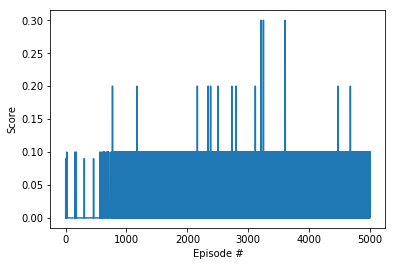

In [26]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(scores) + 1), scores)
ax.set_ylabel('Score')
ax.set_xlabel('Episode #')
fig.savefig("score_x_apisodes.png")
plt.show()

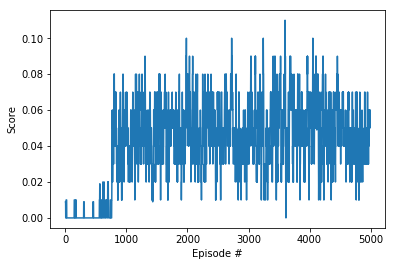

In [27]:
w = 10
mean_score = [np.mean(scores[i-w:i]) for i in range(w,len(scores))]
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(mean_score) + 1), mean_score)
ax.set_ylabel('Score')
ax.set_xlabel('Episode #')
fig.savefig("score_x_apisodes_100.png")
plt.show()